In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('..')
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from utils import *

import wandb
from wandb.xgboost import WandbCallback
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

In [3]:
def post_process_xgb_predictions(predictions, scaler, config_features, lam=None):
    predictions_reshaped = predictions.reshape(-1,1).flatten()
    predictions_reshaped[predictions_reshaped < 0] = 0 # removing negative values
    # reverse the scaling and boxcox transformation of the predictions
    predictions_reshaped = scaler.inverse_transform(predictions_reshaped.reshape(-1,1)).flatten()
    if config_features['boxcox']:
        predictions_reshaped = inverse_boxcox_transform(pd.DataFrame(predictions_reshaped), lam).values.flatten()
    return predictions_reshaped

In [4]:

config_features = {
    'use_holidays': True,
    'boxcox': True,
    'past_info': True,
    'lagged_days': 7,
    'scale_features': True
    }

model_params = { 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor',
    'objective': 'reg:pseudohubererror','colsample_bytree': 1.0,
    'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 200, 
    'subsample': 0.5, 'reg_alpha': 0, 'reg_lambda': 0.5, 'gamma': 0.1
    }


In [16]:
df_first = pd.read_csv(r'data\cleaned_data\5_household\power\SFH36_demand_W.csv', index_col=0, parse_dates=True)

df_first = pd.read_csv(r"C:\Users\nik\iCloudDrive\PhD_Icloud\PhD_Papers\Berkeley\Data\load_data_15min_watts.csv", index_col=0, parse_dates=True).iloc[:,-1:]

# TODO add these steps to data prep notebook

#-----------------------#
df = remove_duplicate_index(df_first)

df[df<=0] = 1e-6 # because of log transform

#-----------------------#


In [17]:
# boxcox transformation

def feature_engineering(df, config_features):

    if config_features['boxcox']:
        df, lam = boxcox_transform(df)


    # scaling the data
    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])

    df = timeseries_dataframe_pivot(df).dropna()
    n_timesteps_per_day = df.shape[1]

    # past information
    lagged_days = config_features['lagged_days']
    if config_features['past_info']:
        df = calc_rolling_sum_of_load(df, 7)
        df["load_of_last_day"] = df.iloc[:,:n_timesteps_per_day].sum(axis=1).shift(1)
        for i in range(2,lagged_days+1):
            df = pd.concat([df, df.iloc[:,:n_timesteps_per_day].shift(i)],axis=1).dropna()

    # holidays
    if config_features['use_holidays']:
        years = get_year_list(df)
        df_holidays_dummies = get_holidays(years, "AT")
        df_holidays = create_holiday_features(df, df_holidays_dummies)
        df = pd.concat([df, df_holidays], axis=1)

    # datetime features
    df = create_datetime_features(df)
    df_final = df.astype('float32').iloc[:-1,:] # last row is nan

    # split the data into train and test

    test_size = 0.2
    train, test = train_test_split(df_final, test_size=test_size, shuffle=False)
    test_idx = unpivot_timeseries_dataframe(test.iloc[:, :n_timesteps_per_day]).index

    train = train.values
    test = test.values

    #features and target
    X_train = train[:,n_timesteps_per_day:]
    y_train = train[:,:n_timesteps_per_day]

    X_test = test[:,n_timesteps_per_day:]
    y_test = test[:,:n_timesteps_per_day]

    # scale the data
    if config_features['scale_features']:
        scaler_features = MinMaxScaler()
        X_train = scaler_features.fit_transform(X_train)
        X_test = scaler_features.transform(X_test)


    return X_train, y_train, X_test, y_test, test_idx, scaler, scaler_features, lam, n_timesteps_per_day


X_train, y_train, X_test, y_test, test_idx, scaler, scaler_features, lam, n_timesteps_per_day = feature_engineering(df, config_features)


In [13]:
# define the model
model = XGBRegressor(
    **model_params)


In [14]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor='gpu_predictor', ...)

In [18]:
predictions = model.predict(X_test)

predictions_reshaped = post_process_xgb_predictions(predictions, scaler, config_features, lam)




In [19]:
# create the persistence benchmarks
gt = df_first.loc[test_idx]
benchmark_day = gt.shift(n_timesteps_per_day).fillna(0).values.flatten() # previous day
benchmark_week = gt.shift(n_timesteps_per_day*7).fillna(0).values.flatten() # same day of previous week
gt = gt.values.flatten()


### Visualization for the resolution

In [20]:
df_compare = pd.DataFrame({'gt':gt, 
                            'predictions': predictions_reshaped,
                            'benchmark_day': benchmark_day,
                            'benchmark_week': benchmark_week}, index=test_idx
                            )[96*7:]

px.line(df_compare,  title='XGBoost Regression')

In [21]:
df_metrics = calc_metrics(df_compare, [mean_squared_error,mean_absolute_error, r2_score])
df_metrics


,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
predictions,406.605288,204.983072,3.225386
benchmark_day,481.286671,229.843285,1.561386
benchmark_week,499.224570,245.908364,1.657477


### Visualization For Daily Energy

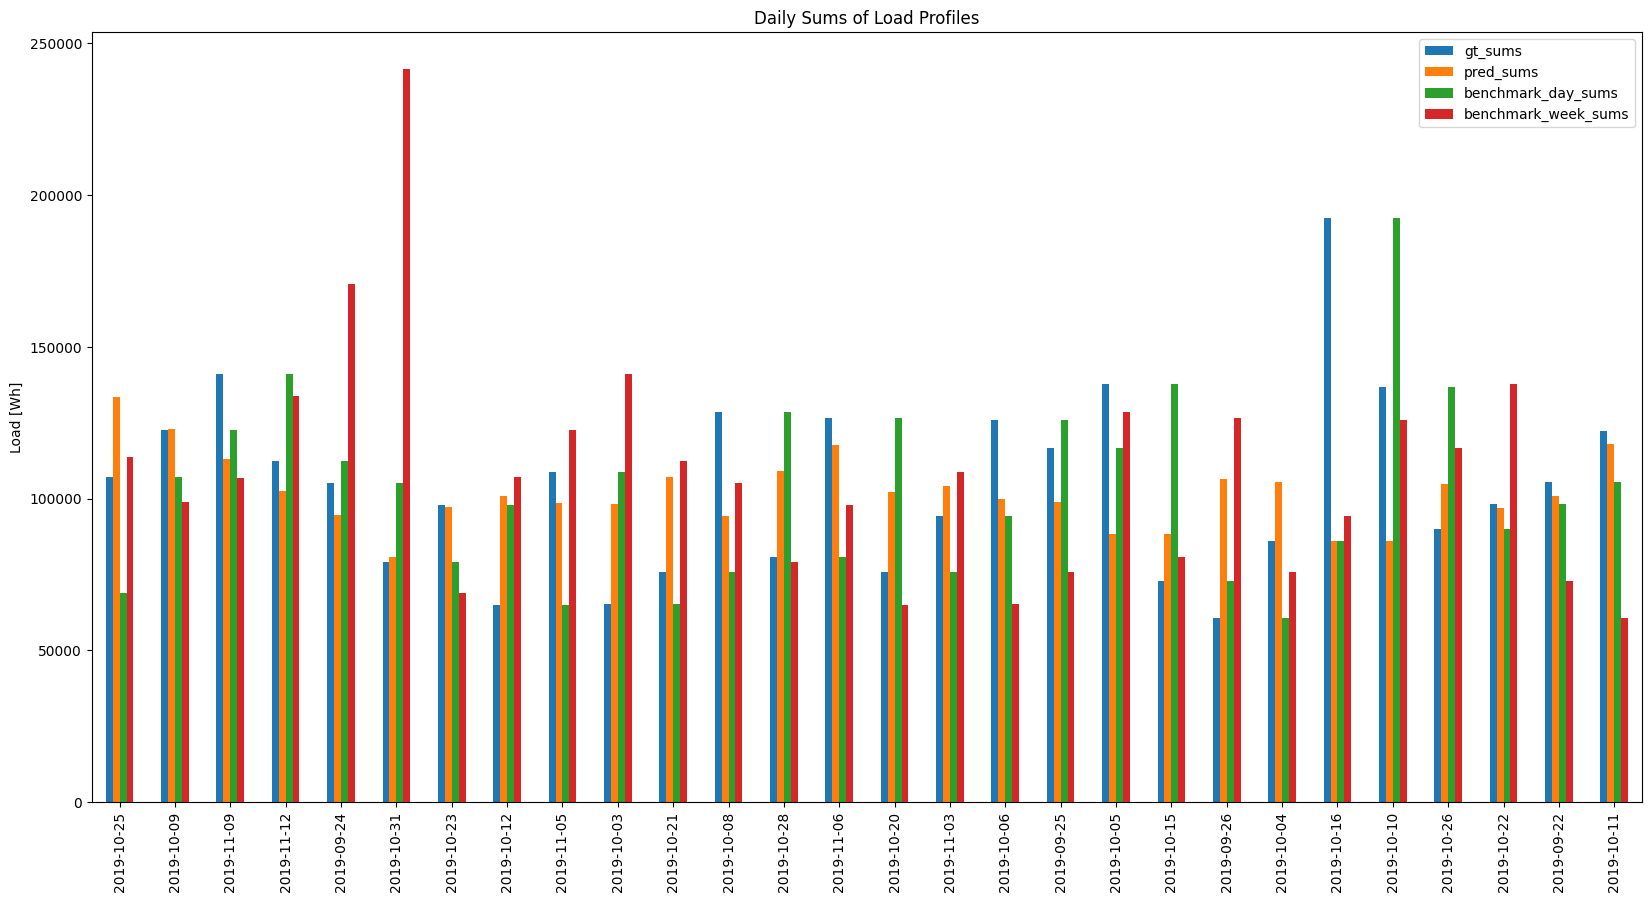

In [14]:

start_later = 7
benchmark_day_per_day = benchmark_day.reshape(predictions.shape)[start_later:]
benchmark_week_per_day = benchmark_week.reshape(predictions.shape)[start_later:]
predictions_per_day = predictions_reshaped.reshape(predictions.shape)[start_later:].sum(axis=1)
gt_per_day = gt.reshape(predictions.shape)[start_later:].sum(axis=1)


df_daily_sum = pd.DataFrame({ 
                            'gt_sums':gt_per_day,
                            'pred_sums': predictions_per_day,
                            'benchmark_day_sums': benchmark_day_per_day.sum(axis=1),
                            'benchmark_week_sums': benchmark_week_per_day.sum(axis=1)
                             }, index=list(set(test_idx.date))[start_later:]
                             )[:28] * 4

df_daily_sum.plot(title='Daily Sums of Load Profiles', kind='bar', figsize=(20,10))
plt.ylabel('Load [Wh]')
plt.show()

In [15]:
df_metrics_daily = calc_metrics(df_daily_sum, [mean_squared_error,mean_absolute_error, r2_score])
df_metrics_daily

,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
pred_sums,31807.895341,23294.429762,7.588424
benchmark_day_sums,39033.249348,32359.395918,1.765949
benchmark_week_sums,50563.713495,37744.213893,1.851204


### Tuning hyperparameters

### Wandb

In [22]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
        'name': 'rmse',
        'goal': 'minimize'
    },
    'parameters': {
        # 'objective': {
        #     'values': ['reg:squarederror', 'reg:pseudohubererror']
        # },
        'learning_rate': {
            'values': [0.01, 0.5]
        },
        'n_estimators': {
            'values': [50, 100]
        },
        # 'lagged_days': {
        #     'values': [1, 2, 3, 4, 5, 6, 7]
        # },
}
}


In [26]:
wandb.init(project="XGBoost")

wandb.config.update(config_features)

In [29]:
wandb.config.lagged_days

7

In [30]:

def train():
    # config_defaults = {'tree_method': 'gpu_hist',
    #                 'predictor': 'gpu_predictor',
    #                 'objective': 'reg:pseudohubererror',
    #                 'eval_metric': 'rmse',
    #                 'colsample_bytree': 1.0, 
    #                 'learning_rate': 0.3,
    #                 'max_depth': 3, 
    #                 'n_estimators': 20,
    #                 'subsample': 0.5, 
    #                 'reg_alpha': 0, 
    #                 'reg_lambda': 0.5, 
    #                 'gamma': 0.1,
        
    # }


    wandb.init(
        #config=config_defaults
        )
    
    #wandb.config.update(config_features)
    
    config = wandb.config




    model = xgb.XGBRegressor(objective=config.objective,
                             learning_rate=config.learning_rate,
                            n_estimators=config.n_estimators)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, eval_metric=config.eval_metric)
    predictions = model.predict(X_test)
    predictions_reshaped = post_process_xgb_predictions(predictions, scaler, config_features, lam)

    # create the persistence benchmarks
    gt = df_first.loc[test_idx].values.flatten()
    df_compare = pd.DataFrame({'gt':gt,
                            'predictions': predictions_reshaped}, 
                            index=test_idx
                            )
    

    # Log the metrics to wandb
    df_metrics = calc_metrics(df_compare, [mean_squared_error,mean_absolute_error, r2_score])
    table = wandb.Table(dataframe=df_metrics.reset_index())
    wandb.log({"metrics": table})


    # Plot the predictions and the ground truth
    rows_to_plot = 4
    fig, ax = plt.subplots(rows_to_plot,1 , figsize=(40,20))
    for i in range(rows_to_plot):
        start = i*192
        end = start + 192
        ax[i].plot(df_compare['gt'][start:end], label='gt')
        ax[i].plot(df_compare['predictions'][start:end], label='predictions')
        ax[i].set_title(f'Day {i+1}')

    # Log the figure to wandb
    wandb.log({"Side-by-Side": wandb.Image(fig)})



sweep_id = wandb.sweep(sweep_config, project="XGBoost")
wandb.agent(sweep_id, train, count=3)
    

    
    

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: dbjms3se
Sweep URL: https://wandb.ai/wattcast/XGBoost/sweeps/dbjms3se


wandb: Agent Starting Run: a9b721o2 with config:
wandb: 	lagged_days: 3
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 100
Exception in thread Exception in thread ChkStopThrNetStatThr:
:
Traceback (most recent call last):
Traceback (most recent call last):
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\threading.py", line 1016, in _bootstrap_inner
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\threading.py", line 953, in run
    self.run()
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\wandb\sdk\wandb_run.py", line 276, in check_stop_status
    self._target(*self._args, **self._kwargs)
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\wandb\sdk\wandb_run.py", line 258, in check_network_status
    self._loop_check_status(
  File "c:\Use

wandb: ERROR Run a9b721o2 errored: AttributeError("<class 'wandb.sdk.wandb_config.Config'> object has no attribute 'objective'")
wandb: Agent Starting Run: vst1e3gz with config:
wandb: 	lagged_days: 1
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 50
